# model

> Defines data and processing structures.

In [ ]:
#| default_exp model

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path
from datetime import datetime, timezone
from matplotlib.pyplot import show
import ipywidgets as w
import multiprocessing

In [ ]:
#| export
from typing import Callable
from matplotlib.figure import Figure
from matplotlib.axes._axes import Axes 

In [ ]:
#| export
from neuralactivitycubic.datamodels import Config
from neuralactivitycubic.processing import AnalysisJob
from neuralactivitycubic.input import RecordingLoaderFactory, ROILoaderFactory, RecordingLoader, ROILoader, get_filepaths_with_supported_extension_in_dirpath, FocusAreaPathRestrictions

In [ ]:
#| export
class Logger:
    def __init__(self):
        self.logs = []

    def add_new_log(self, message: str) -> None:
        time_prefix_in_utc = datetime.now(timezone.utc).strftime('%d-%m-%y %H:%M:%S.%f')
        self.logs.append(f'{time_prefix_in_utc} (UTC): {message}')
        print(f'{time_prefix_in_utc} (UTC): {message}')

    def get_logs(self) -> list[str]:
        return self.logs

    def clear_logs(self) -> None:
        self.logs = []

    def save_current_logs(self, save_dir: Path) -> None:
        filepath = save_dir.joinpath('logs.txt')
        with open(filepath , 'w+') as logs_file:
            for log_message in self.logs:
                logs_file.write(f'{log_message}\n')
        print(f'Logs saved to {filepath}')


In [ ]:
#| export
class Model:

    def __init__(self, config: Config | str) -> None:
        self.num_processes = multiprocessing.cpu_count()
        self.analysis_job_queue = []
        self.logs = Logger()
        if isinstance(config, str):
            config = Config(data_source_path=config)
        self.config = config
        self.gui_enabled = False
        self.callback_view_update_infos = None
        self.callback_view_show_output_screen = None
        self.view_output = None
        self.pixel_conversion = None


    def setup_connection_to_update_infos_in_view(self, update_infos: Callable) -> None:
        self.callback_view_update_infos = update_infos
        self.gui_enabled = True


    def setup_connection_to_display_results(self, show_output_screen: Callable, output: w.Output, pixel_conversion: float) -> None:
        self.callback_view_show_output_screen = show_output_screen
        self.view_output = output
        self.pixel_conversion = pixel_conversion
        self.gui_enabled = True


    def add_info_to_logs(self, message: str, display_in_gui: bool = False, progress_in_percent: float | None = None) -> None:
        self.logs.add_new_log(message)
        if (display_in_gui == True) and (self.gui_enabled == True): 
            self.callback_view_update_infos(message, progress_in_percent)


    def _ensure_data_from_previous_jobs_was_removed(self) -> None:
        # if we are deleting all data anyway, why bother checking?
        if len(self.analysis_job_queue) > 0:
            self.add_info_to_logs('Loading of new source data. All previously created jobs & logs will be deleted.', True)
            self.analysis_job_queue = []
            self.logs.clear_logs()
            # self._check_if_gui_setup_is_completed()

    @staticmethod
    def _get_all_subdir_paths_with_rec_file(top_level_dir_path: Path) -> list[Path]:
        rec_loader_factory = RecordingLoaderFactory()
        supported_extensions_for_recordings = rec_loader_factory.all_supported_extensions
        all_subdir_paths_that_contain_a_supported_recording_file = []
        for elem in top_level_dir_path.iterdir():
            if not elem.name.startswith('.'):
                if elem.is_dir():
                    supported_recording_filepaths = [elem_2 for elem_2 in elem.iterdir() if elem_2.suffix in supported_extensions_for_recordings]
                    if len(supported_recording_filepaths) > 0:
                        all_subdir_paths_that_contain_a_supported_recording_file.append(elem)
        return all_subdir_paths_that_contain_a_supported_recording_file


    def _create_analysis_jobs_for_single_rec(self, recording_path: Path = None) -> None:
        if not recording_path:
            if self.config.recording_filepath:
                recording_path = self.config.recording_filepath
            else:
                recording_path = self.config.data_source_path
        self.add_info_to_logs(f'Starting with Job creation(s) for {str(recording_path)}', True)
        recording_loader = self._get_recording_loader(recording_path)


        if self.config.roi_filepath:
            roi_filepath = self.config.roi_filepath
        else:
            roi_filepath = recording_path
        if self.config.roi_mode == 'file':
            roi_loaders = self._get_all_roi_loaders(roi_filepath)
        else:
            roi_loaders = None

        if self.config.focus_area_filepath:
            focus_area_filepath = self.config.focus_area_filepath
        else:
            focus_area_filepath = recording_path
        if self.config.focus_area_enabled:
            focus_area_dir_path = self._get_focus_area_dir_path(focus_area_filepath)
            if focus_area_dir_path is None:
                analysis_job = self._create_single_analysis_job(recording_loader, roi_loaders)
                self.analysis_job_queue.append(analysis_job)
                self.add_info_to_logs(f'Successfully created a single job for {focus_area_filepath} at queue position: #{len(self.analysis_job_queue)}.', True)
            else:
                all_focus_area_loaders = self._get_all_roi_loaders(focus_area_dir_path)
                assert len(all_focus_area_loaders) > 0, f'Focus Area analysis enabled, but no focus area ROIs could be found. Please revisit your source data and retry!'
                for idx, focus_area_loader in enumerate(all_focus_area_loaders):
                    analysis_job_with_focus_area = self._create_single_analysis_job(recording_loader, roi_loaders, focus_area_loader)
                    self.analysis_job_queue.append(analysis_job_with_focus_area)
                    job_creation_message = (f'Successfully created {idx + 1} out of {len(all_focus_area_loaders)} job(s) for {recording_path} '
                                            f'at queue position: #{len(self.analysis_job_queue)}.')
                    self.add_info_to_logs(job_creation_message, True)
        else:
            analysis_job = self._create_single_analysis_job(recording_loader, roi_loaders)
            self.analysis_job_queue.append(analysis_job)
            self.add_info_to_logs(f'Successfully created a single job for {recording_path} at queue position: #{len(self.analysis_job_queue)}.', True)
        self.add_info_to_logs(f'Finished Job creation(s) for {recording_path}!', True)


    def _get_recording_loader(self, source_path: Path) -> RecordingLoader:
        rec_loader_factory = RecordingLoaderFactory()
        if source_path.is_dir():
            self.add_info_to_logs(f'Looking for a valid recording file in {source_path}...', True)
            valid_filepaths = get_filepaths_with_supported_extension_in_dirpath(source_path, rec_loader_factory.all_supported_extensions, 1)
            if len(valid_filepaths) == 0:
                self.add_info_to_logs(f'Could not find any recording files of supported type at {source_path}!', True)
            elif len(valid_filepaths) >  1:
                filepath = valid_filepaths[0]
                too_many_files_message = (f'Found more than a single recording file of supported type at {source_path}, i.e.: {valid_filepaths}. '
                                          f'However, only a single file was expected. NA3 continues with {filepath} and will ignore the other files.')
                self.add_info_to_logs(too_many_files_message, True)
            else:
                filepath = valid_filepaths[0]
                self.add_info_to_logs(f'Found recording file of supported type at: {filepath}.', True)
        else:
            filepath = source_path
            self.add_info_to_logs(f'Found recording file of supported type at: {filepath}.', True)
        recording_loader = rec_loader_factory.get_loader(filepath)
        return recording_loader


    def _get_all_roi_loaders(self, data_source_path: Path) -> list[ROILoader]:
        assert data_source_path.is_dir(), f'You must provide a directory as source data when using ROI mode or enabling Focus Areas. Please revisit your input data and retry.'
        roi_loader_factory = ROILoaderFactory()
        all_filepaths_with_supported_filetype_extensions = get_filepaths_with_supported_extension_in_dirpath(data_source_path, roi_loader_factory.all_supported_extensions)
        all_roi_loaders = [roi_loader_factory.get_loader(roi_filepath) for roi_filepath in all_filepaths_with_supported_filetype_extensions]
        return all_roi_loaders


    def _get_focus_area_dir_path(self, source_path: Path) -> Path:
        focus_area_path_restrictions = FocusAreaPathRestrictions()
        supported_dir_names = focus_area_path_restrictions.supported_dir_names
        if source_path.is_dir():
            source_dir_path = source_path
        else:
            source_dir_path = source_path.parent
        dirs_with_valid_name = [elem for elem in source_dir_path.iterdir() if (elem.name in supported_dir_names) & (elem.is_dir() == True)]
        if len(dirs_with_valid_name) == 0:
            no_dir_found_message = (f'You enabled Focus Area but a correspondingly named directory could not be found in {source_dir_path}. '
                                    f'Please use one of the following for the name of the directory that contains the Focus Area ROIs: {supported_dir_names}. '
                                    'In absence of such a directory, analysis is continued without using the Focus Area mode for this data.')
            self.add_info_to_logs(no_dir_found_message, True)
            focus_area_dir_path = None
        elif len(dirs_with_valid_name) > 1:
            too_many_dirs = (f'More than a single Focus Area directory was found in the following parent directory: {source_dir_path}, i.e.: '
                             f'{dirs_with_valid_name}. However, only the use of a single one that contains all your Focus Area ROIS is '
                             f'currently supported. {dirs_with_valid_name[0]} will be used for this analysis, while the other(s): {dirs_with_valid_name[1:]} '
                             'will be ignored to continue processing.')
            self.add_info_to_logs(too_many_dirs, True)
            focus_area_dir_path = dirs_with_valid_name[0]
        else:
            focus_area_dir_path = dirs_with_valid_name[0]
        return focus_area_dir_path


    def _create_single_analysis_job(self, recording_loader: RecordingLoader, roi_loaders: list[ROILoader] | None, focus_area_loader: ROILoader | None = None) -> AnalysisJob:
        data_loaders = {'recording': recording_loader}
        if roi_loaders is not None:
            data_loaders['rois'] = roi_loaders
        if focus_area_loader is not None:
            data_loaders['focus_area'] = focus_area_loader
        return AnalysisJob(self.num_processes, data_loaders, self.config.results_filepath)


    def _display_configs(self) -> None:
        self.add_info_to_logs('Configurations for Analysis Settings and Result Creation validated successfully.', True)
        self.add_info_to_logs(f'Analysis Settings are:')
        for line in self.config.display_all_attributes():
            self.add_info_to_logs(line)

    def _save_user_settings_as_json(self, analysis_job: AnalysisJob) -> None:
        filepath = analysis_job.results_dir_path.joinpath('user_settings.json')
        self.config.recording_filepath = analysis_job.recording.filepath
        if analysis_job.focus_area_enabled:
            self.config.focus_area_filepath = analysis_job.focus_area.filepath
        else:
            self.config.focus_area_filepath = None
        if analysis_job.rois_source == 'file':
            self.config.roi_filepath = [roi.filepath for roi in analysis_job.all_rois]
        with open(filepath, 'w+') as user_settings_json:
            user_settings_json.write(self.config.to_json())


    def create_analysis_jobs(self) -> None:
        self._ensure_data_from_previous_jobs_was_removed()
        self.add_info_to_logs('Basic configurations for data import validated. Starting creation of analysis job(s)...', True)
        if self.config.batch_mode:
            all_subdir_paths_with_rec_file = self._get_all_subdir_paths_with_rec_file(self.config.data_source_path)
            all_subdir_paths_with_rec_file.sort()
            for idx, subdir_path in enumerate(all_subdir_paths_with_rec_file):
                self._create_analysis_jobs_for_single_rec(subdir_path)
        else:
            self._create_analysis_jobs_for_single_rec()
        self.add_info_to_logs('All job creation(s) completed.', True, 100.0)

    def run_analysis(self) -> None:
        self._display_configs()
        self.add_info_to_logs('Starting analysis...', True)
        for job_idx, analysis_job in enumerate(self.analysis_job_queue):
            self.add_info_to_logs(f'Starting to process analysis job with index #{job_idx}.')
            analysis_job.run_analysis(self.config)
            self.add_info_to_logs(f'Analysis successfully completed. Continue with creation of results.. ')
            analysis_job.create_results(self.config)
            self.add_info_to_logs(f'Results successfully created at: {analysis_job.results_dir_path}')
            if self.gui_enabled:
                self.callback_view_show_output_screen()
                with self.view_output:
                    activity_overview_fig = analysis_job.activity_overview_plot[0]
                    activity_overview_fig.set_figheight(400 * self.pixel_conversion)
                    activity_overview_fig.tight_layout()
                    show(activity_overview_fig)
            self._save_user_settings_as_json(analysis_job)
            self.logs.save_current_logs(analysis_job.results_dir_path)
        self.add_info_to_logs('Updating all log files to contain all logs as final step. All valid logs files will end with this message.')
        for job_idx, analysis_job in enumerate(self.analysis_job_queue):
            self.logs.save_current_logs(analysis_job.results_dir_path)


    def preview_window_size(self, grid_size) -> tuple[Figure, Axes]:
        job_for_preview = self.analysis_job_queue[0]
        preview_fig, preview_ax = job_for_preview.preview_window_size(grid_size)
        return preview_fig, preview_ax

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

Setup for testing:

In [ ]:
from shutil import rmtree
import pandas as pd
from pandas.testing import assert_frame_equal

from neuralactivitycubic.view import WidgetsInterface

test_filepath = Path('../test_data/00')
example_results_dir = Path('../test_data/00/example_test_results_for_spiking_neuron')
results_filepath = Path('../test_data/00/results_directory')


def test_correct_model_run():
    correct_config = WidgetsInterface().export_user_settings()
    correct_config.data_source_path = test_filepath / 'spiking_neuron.avi'
    correct_config.save_single_trace_results = True
    model = Model(correct_config)
    model.create_analysis_jobs()
    model.run_analysis()
    # evil hacks
    return model.analysis_job_queue[0].results_dir_path

def test_correct_model_run_with_custom_results_dir():
    correct_config = WidgetsInterface().export_user_settings()
    correct_config.data_source_path = test_filepath / 'spiking_neuron.avi'
    correct_config.results_filepath = results_filepath
    model = Model(correct_config)
    model.create_analysis_jobs()
    model.run_analysis()
    return correct_config.results_filepath

In [ ]:
def _test_csv_files(relative_filepath_to_csv: str, results_dir: Path) -> bool:
    filepath = results_dir / relative_filepath_to_csv
    # confirm results have been created:
    if not filepath.is_file():
        return False
    # confirm computational consistency of results, while allowing minor numerical tolerance
    df_test = pd.read_csv(filepath)
    df_validation = pd.read_csv(example_results_dir / relative_filepath_to_csv)
    if assert_frame_equal(df_test, df_validation) is not None:
        return False
    else:
        return True

def test_all_peak_results(results_dir):
    return _test_csv_files('all_peak_results.csv', results_dir)

def test_amplitude_and_df_over_f_results(results_dir):
    return _test_csv_files('Amplitude_and_dF_over_F_results.csv', results_dir)

def test_auc_results(results_dir):
    return _test_csv_files('AUC_results.csv', results_dir)

def test_variance_area_results(results_dir):
    return _test_csv_files('Variance_area_results.csv', results_dir)

def test_representative_single_trace_results(results_dir):
    return _test_csv_files('single_traces/data_of_ROI_7-10.csv', results_dir)

In [ ]:
def test_activity_overview_png(results_dir):
    filepath = results_dir / 'activity_overview.png'
    return filepath.is_file()

def test_roi_label_ids_overview_png(results_dir):
    filepath = results_dir / 'ROI_label_IDs_overview.png'
    return filepath.is_file()

def test_individual_traces_with_identified_events_pdf(results_dir):
    filepath = results_dir / 'Individual_traces_with_identified_events.pdf'
    return filepath.is_file()

def test_logs_txt(results_dir):
    filepath = results_dir / 'logs.txt'
    return filepath.is_file()

def test_user_settings_json(results_dir):
    filepath = results_dir / 'user_settings.json'
    return filepath.is_file()

def test_nwb_export(results_dir):
    filepath = results_dir / 'autogenerated_nwb_file.nwb'

Run tests:

02-07-25 12:00:54.655666 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
02-07-25 12:00:54.655714 (UTC): Starting with Job creation(s) for ../test_data/00/spiking_neuron.avi
02-07-25 12:00:54.655767 (UTC): Found recording file of supported type at: ../test_data/00/spiking_neuron.avi.
02-07-25 12:00:54.655823 (UTC): Successfully created a single job for ../test_data/00/spiking_neuron.avi at queue position: #1.
02-07-25 12:00:54.655838 (UTC): Finished Job creation(s) for ../test_data/00/spiking_neuron.avi!
02-07-25 12:00:54.655845 (UTC): All job creation(s) completed.
02-07-25 12:00:54.655853 (UTC): Configurations for Analysis Settings and Result Creation validated successfully.
02-07-25 12:00:54.655861 (UTC): Analysis Settings are:
02-07-25 12:00:54.655918 (UTC): batch_mode: False
02-07-25 12:00:54.655927 (UTC): baseline_estimation_method: asls
02-07-25 12:00:54.655933 (UTC): customize_octave_filtering: False
02-07-25 12:00:54.655940 (UTC):

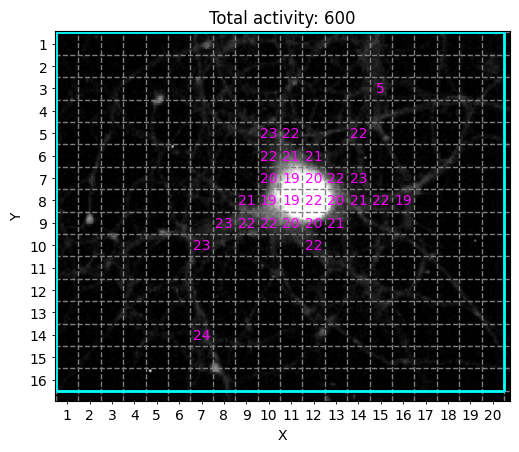

In [ ]:
# confirm that model can be executed:
results_directory = test_correct_model_run()

assert results_directory.exists()

# confirm all csv files have been created and are correct:
assert test_all_peak_results(results_directory), 'There is an issue with the "all_peak_results.csv" file!'
assert test_amplitude_and_df_over_f_results(results_directory)
assert test_auc_results(results_directory)
assert test_variance_area_results(results_directory)
assert test_representative_single_trace_results(results_directory)

# confirm all other result files have been created:
assert test_activity_overview_png(results_directory)
assert test_roi_label_ids_overview_png(results_directory)
assert test_individual_traces_with_identified_events_pdf(results_directory)
assert test_logs_txt(results_directory)
assert test_user_settings_json(results_directory)

# cleanup
rmtree(results_directory)

02-07-25 12:00:58.375384 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
02-07-25 12:00:58.375449 (UTC): Starting with Job creation(s) for ../test_data/00/spiking_neuron.avi
02-07-25 12:00:58.375495 (UTC): Found recording file of supported type at: ../test_data/00/spiking_neuron.avi.
02-07-25 12:00:58.375540 (UTC): Successfully created a single job for ../test_data/00/spiking_neuron.avi at queue position: #1.
02-07-25 12:00:58.375549 (UTC): Finished Job creation(s) for ../test_data/00/spiking_neuron.avi!
02-07-25 12:00:58.375556 (UTC): All job creation(s) completed.
02-07-25 12:00:58.375563 (UTC): Configurations for Analysis Settings and Result Creation validated successfully.
02-07-25 12:00:58.375571 (UTC): Analysis Settings are:
02-07-25 12:00:58.375635 (UTC): batch_mode: False
02-07-25 12:00:58.375645 (UTC): baseline_estimation_method: asls
02-07-25 12:00:58.375652 (UTC): customize_octave_filtering: False
02-07-25 12:00:58.375659 (UTC):

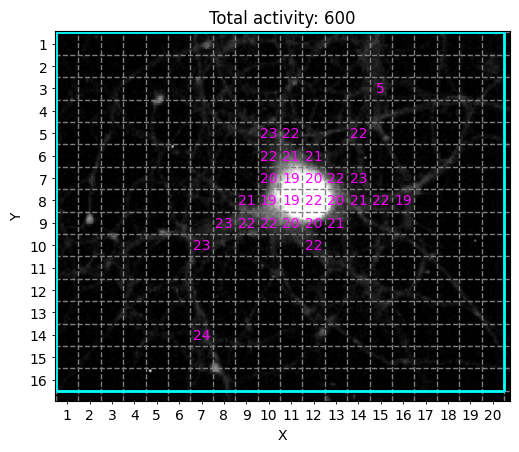

In [ ]:
# confirm that model can be executed with custom results directory:
results_directory = test_correct_model_run_with_custom_results_dir()

assert results_directory.exists()

# confirm all csv files have been created and are correct:
assert test_all_peak_results(results_directory), 'There is an issue with the "all_peak_results.csv" file!'
assert test_amplitude_and_df_over_f_results(results_directory)
assert test_auc_results(results_directory)
assert test_variance_area_results(results_directory)

# confirm all other result files have been created:
assert test_activity_overview_png(results_directory)
assert test_roi_label_ids_overview_png(results_directory)
assert test_logs_txt(results_directory)
assert test_user_settings_json(results_directory)

# cleanup
rmtree(results_directory)